imports and data update
-----------

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
import os
from scipy import stats
import colorcet as cc
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
# upload data
cpath = os.getcwd() #assumes mean_df_females is in the same path as the notebook
female_mean_df = pd.read_csv(cpath+'/mean_df_female.csv')
female_mean_df = female_mean_df[female_mean_df['rep']!=1] #balance female/male dataset
female_mean_df['rep'] = female_mean_df['rep']-1 # rename repetitions
male_mean_df = pd.read_csv(cpath+'/mean_df_male.csv')

In [3]:
# use first half of female data and second half of male data
female_mean_df = female_mean_df[female_mean_df['rep']<8]
print(sorted(female_mean_df.rep.unique()))
male_mean_df = male_mean_df[male_mean_df['rep']>7]
print(sorted(male_mean_df.rep.unique()))

[1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 14]


# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [4]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")
cmap2= ['#6C6295','#FBB040']

## functions

In [5]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    return cohort_dist

## KLD analysis females

In [6]:
# KLD between mice (average syllable use per mouse)
mm=[]
temp_mean_df= female_mean_df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
KLD_indv = KLD_analysis(mm)
mean_kld_indv = np.mean(KLD_indv,axis=0)

# KLD between repetitions (within mouse)
temp_mean_df = female_mean_df.groupby(by = ['mouse', 'rep', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)

mean_kld_rep=[]
mice = mean_df_lc['mouse'].unique()
for choose in mice:
        curr = mean_df_lc[mean_df_lc['mouse'] == choose]
        curr = curr.drop(['mouse','rep'], axis=1).to_numpy()
        KLD_phase = KLD_analysis(curr)
        mean_kld_rep.append(np.mean(KLD_phase))

# for all sessions
mean_kld_all=[]
data_all=mean_df_lc.drop(['mouse','rep'], axis=1).to_numpy()
kld_all=KLD_analysis(data_all)
mean_kld_all = np.mean(kld_all,axis=0)
mean_kld_all = np.mean(kld_all,axis=0)

In [7]:
# create dataframe for plotting
kld = np.concatenate((np.array(mean_kld_all),
                      np.array(mean_kld_indv),
                      np.array(mean_kld_rep)))
groups = np.concatenate((len(np.array(mean_kld_all)) * ['fall'],
                         len(np.array(mean_kld_indv)) * ['finter-indv'],
                         len(np.array(mean_kld_rep)) * ['fintra-indv']))
sex= len(kld) * ['female']

fklddata = {'KLD': list(kld), 
           'groups': list(groups),
           'sex':list(sex)}
# Create DataFrame
fdf = pd.DataFrame(fklddata)
fdf = fdf[(fdf != 0).all(1)] # remove self distance

## KLD analysis males

In [8]:
# KLD between mice (average syllable use per mouse)
mm=[]
temp_mean_df= male_mean_df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
KLD_indv = KLD_analysis(mm)
mean_kld_indv = np.mean(KLD_indv,axis=0)

# KLD between repetitions (within mouse)
temp_mean_df = male_mean_df.groupby(by = ['mouse', 'rep', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)

mean_kld_rep=[]
mice = mean_df_lc['mouse'].unique()
for choose in mice:
        curr = mean_df_lc[mean_df_lc['mouse'] == choose]
        curr = curr.drop(['mouse','rep'], axis=1).to_numpy()
        KLD_phase = KLD_analysis(curr)
        mean_kld_rep.append(np.mean(KLD_phase))

# for all sessions
mean_kld_all=[]
data_all=mean_df_lc.drop(['mouse','rep'], axis=1).to_numpy()
kld_all=KLD_analysis(data_all)
mean_kld_all = np.mean(kld_all,axis=0)

In [9]:
# create dataframe for plotting
kld = np.concatenate((np.array(mean_kld_all),
                      np.array(mean_kld_indv),
                      np.array(mean_kld_rep)))
groups = np.concatenate((len(np.array(mean_kld_all)) * ['mall'],
                         len(np.array(mean_kld_indv)) * ['minter-indv'],
                         len(np.array(mean_kld_rep)) * ['mintra-indv']))
sex= len(kld) * ['male']
mklddata = {'KLD': list(kld), 
           'groups': list(groups),
           'sex':list(sex)}
mdf = pd.DataFrame(mklddata)
mdf = mdf[(mdf != 0).all(1)] # remove self distance

Compare male and female KLD
----------

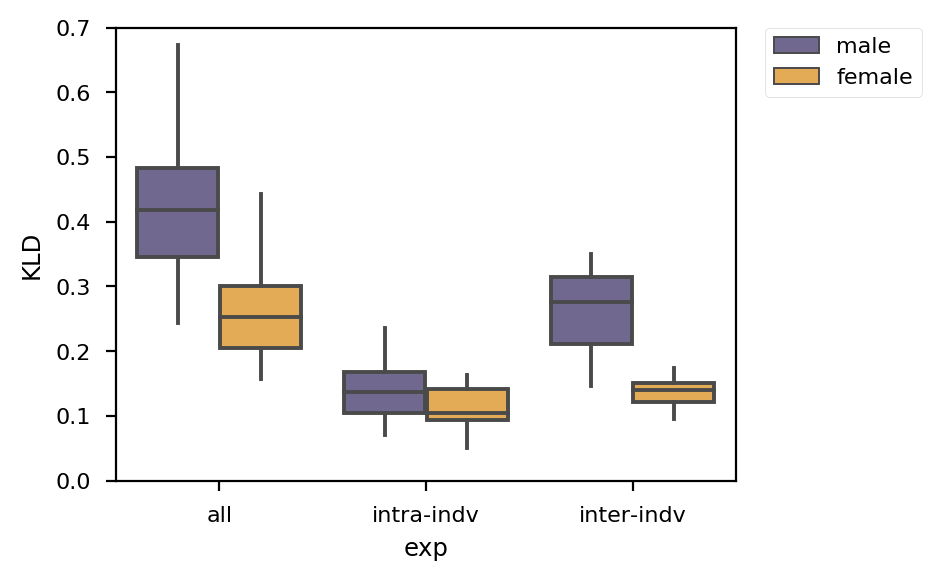

In [10]:
#### plot all
klds = pd.concat([mdf,fdf])
klds['exp'] = klds.groups.str[1:]

# boxplot
fig = plt.figure(figsize=(4,3))
fig.dpi = 200
plt.ylim([0,0.7])
ax = sns.boxplot(x="exp",y="KLD",data=klds, order=['all','intra-indv','inter-indv'],
                 hue='sex', hue_order=["male", "female"],
                 showfliers=False, showcaps=False, palette = cmap2)
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0)

fig.savefig(data_loc +'mf_kld_7days.pdf', bbox_inches='tight')

## KLD statistics

In [11]:
# statistics
#2-way anova
print ('2-way anova')
#perform anova
formula = 'KLD ~ C(sex) + C(exp) + C(sex):C(exp)'
model = ols(formula, data=klds).fit()
an_table=sm.stats.anova_lm(model, typ=2)
print(an_table)

print ('ttest')
from scipy.stats import ttest_ind
pvsp= ttest_ind (klds[klds.groups=='mall'].KLD, klds[klds.groups=='fall'].KLD, equal_var=False)
print('for all data: ', str(pvsp.pvalue))
pvsp= ttest_ind (klds[klds.groups=='mintra-indv'].KLD, klds[klds.groups=='fintra-indv'].KLD, equal_var=False)
print('for intra-indv: ', str(pvsp.pvalue))
pvsp= ttest_ind (klds[klds.groups=='minter-indv'].KLD, klds[klds.groups=='finter-indv'].KLD, equal_var=False)
print('for inter-indv: ', str(pvsp.pvalue))

2-way anova
                  sum_sq     df          F        PR(>F)
C(sex)          2.083712    1.0  34.805171  1.183797e-08
C(exp)          2.205182    2.0  18.417073  3.472260e-08
C(sex):C(exp)   0.233149    2.0   1.947193  1.448403e-01
Residual       14.907102  249.0        NaN           NaN
ttest
for all data:  3.631486632320103e-07
for intra-indv:  0.05859731408393813
for inter-indv:  9.681939338926372e-07


# CV females

In [12]:
# CV between mice (average syllable use per mouse)
mm=[]
temp_mean_df= female_mean_df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
sys=np.nanstd(np.array(mm), axis=0)
sym=np.nanmean(np.array(mm), axis=0)
cv_indv=sys/sym # each syllable will have a cv value

# CV between repetitions (within mouse)
cv_rep=[]
temp_mean_df = female_mean_df.groupby(by = ['mouse', 'rep', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)
mice = mean_df_lc['mouse'].unique()
for choose in mice:
    curr = mean_df_lc[mean_df_lc['mouse'] == choose]
    curr = curr.drop(['mouse','rep'], axis=1).to_numpy()
    sys=np.nanstd(np.array(curr), axis=0)
    sym=np.nanmean(np.array(curr), axis=0)
    cv_rep.append(sys/sym)
mean_cv_rep = np.mean(cv_rep,axis=0)

# for all sessions
mean_kld_all=[]
data_all=mean_df_lc.drop(['mouse','rep'], axis=1).to_numpy()
cv_all=np.nanstd(np.array(data_all), axis=0)/np.nanmean(np.array(data_all), axis=0)

In [13]:
# create dataframe for plotting
cv = np.concatenate((np.array(cv_all),
                      np.array(cv_indv),
                      np.array(mean_cv_rep)))
groups = np.concatenate((len(np.array(cv_all)) * ['fall'],
                         len(np.array(cv_indv)) * ['finter-indv'],
                         len(np.array(mean_cv_rep)) * ['fintra-indv']))
sex= len(cv) * ['female']
fcvdata = {'cv': list(cv),
           'sex':list(sex),
           'groups': list(groups)}
fcvdf = pd.DataFrame(fcvdata)

# CV males

In [14]:
# CV between mice (average syllable use per mouse)
mm=[]
temp_mean_df= male_mean_df.groupby(by = ['mouse', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse'], columns=['syllable']).reset_index().fillna(0)
mm=mean_df_lc.drop(['mouse'], axis=1).to_numpy()
sys=np.nanstd(np.array(mm), axis=0)
sym=np.nanmean(np.array(mm), axis=0)
cv_indv=sys/sym # each syllable will have a cv value

# CV between repetitions (within mouse)
cv_rep=[]
temp_mean_df = male_mean_df.groupby(by = ['mouse', 'rep', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)
mice = mean_df_lc['mouse'].unique()
for choose in mice:
    curr = mean_df_lc[mean_df_lc['mouse'] == choose]
    curr = curr.drop(['mouse','rep'], axis=1).to_numpy()
    sys=np.nanstd(np.array(curr), axis=0)
    sym=np.nanmean(np.array(curr), axis=0)
    cv_rep.append(sys/sym)
mean_cv_rep = np.mean(cv_rep,axis=0)

# for all sessions
mean_kld_all=[]
data_all=mean_df_lc.drop(['mouse','rep'], axis=1).to_numpy()
cv_all=np.nanstd(np.array(data_all), axis=0)/np.nanmean(np.array(data_all), axis=0)

In [15]:
# create dataframe and save for female
cv = np.concatenate((np.array(cv_all),
                      np.array(cv_indv),
                      np.array(mean_cv_rep)))
groups = np.concatenate((len(np.array(cv_all)) * ['mall'],
                         len(np.array(cv_indv)) * ['minter-indv'],
                         len(np.array(mean_cv_rep)) * ['mintra-indv']))
sex= len(cv) * ['male']
mcvdata = {'cv': list(cv), 
           'sex':list(sex),
           'groups': list(groups)}
# Create DataFrame
mcvdf = pd.DataFrame(mcvdata)

# compare males and females CV

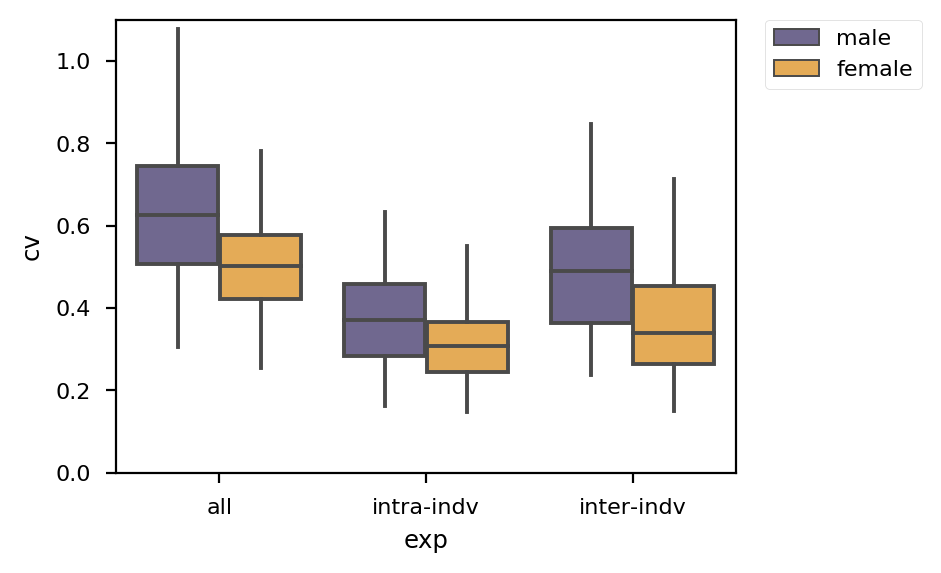

In [16]:
#### plot all
cvs = pd.concat([mcvdf,fcvdf])
cvs['exp'] = cvs.groups.str[1:]

# boxplot
fig = plt.figure(figsize=(4,3))
fig.dpi = 200
plt.ylim([0,1.1])
ax = sns.boxplot(x="exp",y="cv",data=cvs, order=['all','intra-indv','inter-indv'],
                 hue='sex', hue_order=["male", "female"],
                 showfliers=False, showcaps=False,palette = cmap2)
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0)
fig.savefig(data_loc +'mf_cv_7days.pdf', bbox_inches='tight')

In [17]:
# statistics
print ('2-way anova')
#perform anova
formula = 'cv ~ C(sex) + C(exp) + C(sex):C(exp)'
model = ols(formula, data=cvs).fit()
an_table=sm.stats.anova_lm(model, typ=2)
print(an_table)

print ('ttest')
from scipy.stats import ttest_ind
pvsp= ttest_ind (cvs[cvs.groups=='mall'].cv, cvs[cvs.groups=='fall'].cv, equal_var=False)
print('for all data: ', str(pvsp.pvalue))
pvsp= ttest_ind (cvs[cvs.groups=='mintra-indv'].cv, cvs[cvs.groups=='fintra-indv'].cv, equal_var=False)
print('for intra indv: ', str(pvsp.pvalue))
pvsp= ttest_ind (cvs[cvs.groups=='minter-indv'].cv, cvs[cvs.groups=='finter-indv'].cv, equal_var=False)
print('for inter indv: ', str(pvsp.pvalue))

2-way anova
                 sum_sq     df          F        PR(>F)
C(sex)         0.776756    1.0  31.743366  4.186698e-08
C(exp)         2.763351    2.0  56.464381  2.045688e-21
C(sex):C(exp)  0.085503    2.0   1.747113  1.761182e-01
Residual       7.047320  288.0        NaN           NaN
ttest
for all data:  0.0009521242170266346
for intra indv:  0.012846444262019535
for inter indv:  0.0003004494766345169
